# 230. mnist dataset 손글씨 인식 - LeNet

- CNN 을 이용한 mnist dataset 손글씨 인식  
- Yan LeCunn 이 1998 년 발표한 LeNet-5 을 Pytorch 로 customize 하여 재현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
composed = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1,), (0.3,))])

In [4]:
train_data = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

test_data = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [5]:
print(train_data)
print()
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1,), std=(0.3,))
           )

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1,), std=(0.3,))
           )


- Data 시각화

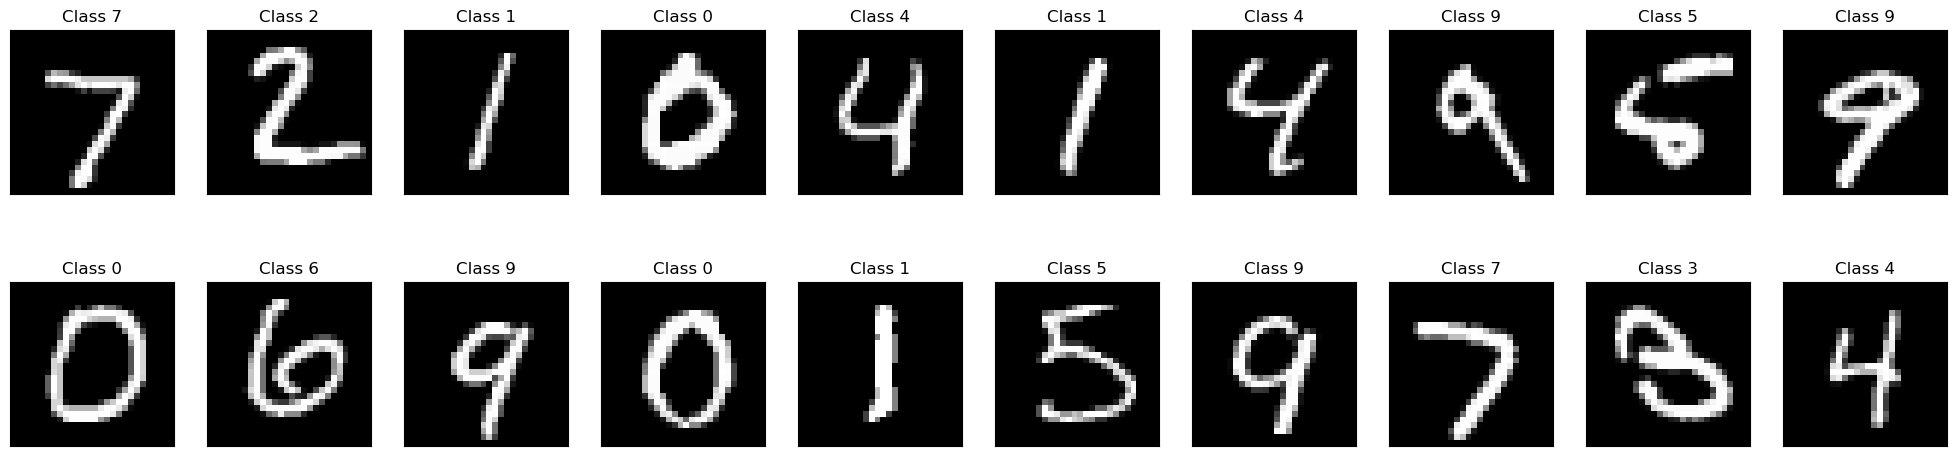

In [6]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')  
    plt.title("Class {}".format(y))
    plt.xticks([])
    plt.yticks([])

plt.show()

### Dataset Loader 생성
- Train dataset 을 Train 와 Validation 으로 분리

In [7]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print(len(train_idx), len(valid_idx))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

48000 12000


- train, validation, test dataset 으로 3 분할

In [8]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, sampler=valid_sampler)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, 
                                           batch_size=batch_size, shuffle=False)

## Model build

<img src="https://d2l.ai/_images/lenet.svg" width="800" />

In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(2),  #pool size = 2
                nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Flatten(),
                nn.Linear(16 * 5 * 5, 120),
                nn.ReLU(),
                nn.Linear(120, 84),
                nn.ReLU(),
                nn.Linear(84, 10)
        )
        
    def forward(self, x):
        logits = self.conv_relu_stack(x)
        return logits

In [10]:
model = LeNet()
model

LeNet(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

Train 전에 모델이 작동하는지 test

In [11]:
next(iter(train_loader))[0].shape

torch.Size([128, 1, 28, 28])

In [12]:
logits = model(next(iter(train_loader))[0][0:1])
logits

tensor([[ 0.0319,  0.0158, -0.0463, -0.0163,  0.0191,  0.0213,  0.0679,  0.0749,
          0.0488, -0.1549]], grad_fn=<AddmmBackward0>)

In [13]:
softmax = nn.Softmax(dim=1)
pred = softmax(logits)[0]
print(pred)
print(sum(pred).item())

tensor([0.1024, 0.1008, 0.0947, 0.0976, 0.1011, 0.1013, 0.1062, 0.1069, 0.1041,
        0.0850], grad_fn=<SelectBackward0>)
1.0000001192092896


### Model Summary

In [14]:
for k, v in model.state_dict().items():
    print(k, v.numel())

print("Total parameters :", sum(p.numel() for p in model.parameters()))

conv_relu_stack.0.weight 150
conv_relu_stack.0.bias 6
conv_relu_stack.3.weight 2400
conv_relu_stack.3.bias 16
conv_relu_stack.7.weight 48000
conv_relu_stack.7.bias 120
conv_relu_stack.9.weight 10080
conv_relu_stack.9.bias 84
conv_relu_stack.11.weight 840
conv_relu_stack.11.bias 10
Total parameters : 61706


### Loss Function

In [15]:
criterion = nn.CrossEntropyLoss()

model.to(device)

LeNet(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [16]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [17]:
LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []
EPOCHS = 30

for epoch in range(EPOCHS):
    
    model.train()  # train mode
    
    train_loss = 0
    train_acc = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        z = model(x)
        loss = criterion(z, y)
        train_loss += loss.item()
        _, y_pred = torch.max(z, 1)  #(max values, indices)
        train_acc += (y_pred == y).sum().item() / len(y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    train_loss = train_loss/len(train_loader)
    train_acc = train_acc/len(train_loader)
    LOSS.append(train_loss)
    ACC.append(train_acc)
    
    model.eval()   # evaluation mode
        
    val_loss = 0
    val_acc = 0
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        
        z = model(x)
        loss = criterion(z, y)
        
        val_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        val_acc += (y_pred == y).sum().item() / len(y)
        
    val_loss = val_loss / len(valid_loader)
    val_acc  = val_acc / len(valid_loader)
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)
    
    print(f'epoch {epoch} ==> train loss: {train_loss:.5f},  valididation loss: {val_loss:.5f}',  
                                            f'train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

epoch 0 ==> train loss: 1.75174,  valididation loss: 0.57255 train acc: 0.48435, validation acc: 0.82150
epoch 1 ==> train loss: 0.38584,  valididation loss: 0.31608 train acc: 0.88317, validation acc: 0.90467
epoch 2 ==> train loss: 0.23129,  valididation loss: 0.19235 train acc: 0.92971, validation acc: 0.94265
epoch 3 ==> train loss: 0.17031,  valididation loss: 0.15132 train acc: 0.94785, validation acc: 0.95531
epoch 4 ==> train loss: 0.13546,  valididation loss: 0.12126 train acc: 0.95888, validation acc: 0.96454
epoch 5 ==> train loss: 0.11400,  valididation loss: 0.10658 train acc: 0.96500, validation acc: 0.96750
epoch 6 ==> train loss: 0.10009,  valididation loss: 0.09419 train acc: 0.96946, validation acc: 0.97288
epoch 7 ==> train loss: 0.08957,  valididation loss: 0.09234 train acc: 0.97240, validation acc: 0.97418
epoch 8 ==> train loss: 0.08148,  valididation loss: 0.09308 train acc: 0.97462, validation acc: 0.97210
epoch 9 ==> train loss: 0.07602,  valididation loss: 0.

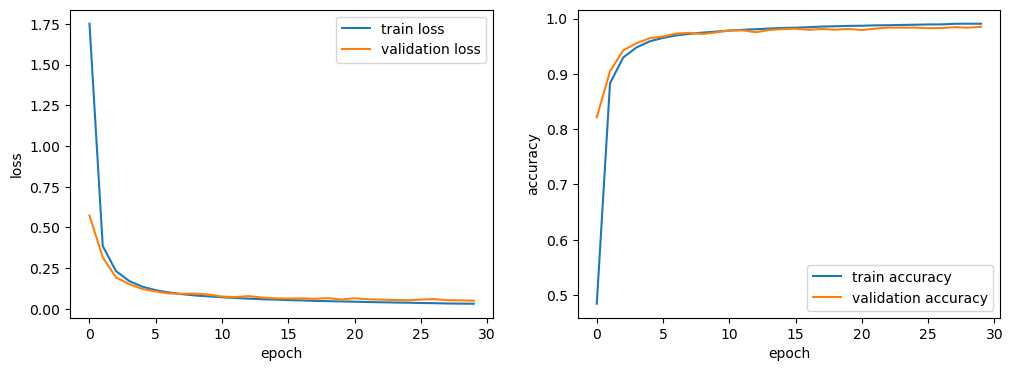

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(LOSS, label='train loss')
ax1.plot(VAL_LOSS, label='validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(ACC, label='train accuracy')
ax2.plot(VAL_ACC, label='validation accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

## Model 평가 - Test set 사용 

In [19]:
predictions = []
labels = []

model.eval()

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    z = model(x)
    _, y_pred = torch.max(z, 1)
    
    predictions.extend(y_pred.cpu().numpy())
    labels.extend(y.cpu().numpy())
    
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]
    
print("accuracy = {:.2f}%".format(len(correct_indices) / len(predictions) * 100))

accuracy = 98.86%


## Category 별 분류 성능 측정

accuracy of 0 = 99.59%
accuracy of 1 = 99.38%
accuracy of 2 = 98.64%
accuracy of 3 = 98.81%
accuracy of 4 = 99.49%
accuracy of 5 = 99.22%
accuracy of 6 = 98.43%
accuracy of 7 = 99.12%
accuracy of 8 = 98.46%
accuracy of 9 = 97.42%


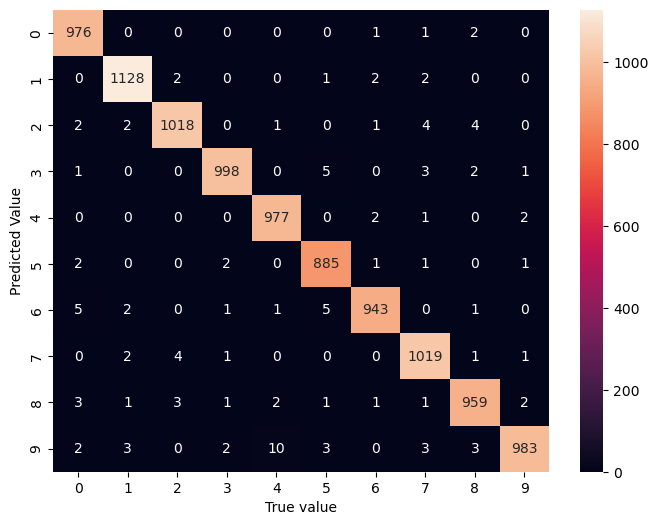

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted Value')

for i in range(10):
    print(f"accuracy of {i} = {cm[i][i] / cm[i].sum() * 100:.2f}%")

# 실습 : fashion MNIST 를 이용하여 위와 동일한 작업

Label	Class

0	T-shirt/top  
1	Trouser  
2	Pullover  
3	Dress  
4	Coat  
5	Sandal  
6	Shirt  
7	Sneaker  
8	Bag  
9	Ankle boot

In [21]:
composed = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1,), (0.3,))])

In [22]:
# load mnist data
train_data = dsets.FashionMNIST(root='./data', train=True, download=True, transform=composed)

test_data = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

In [23]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

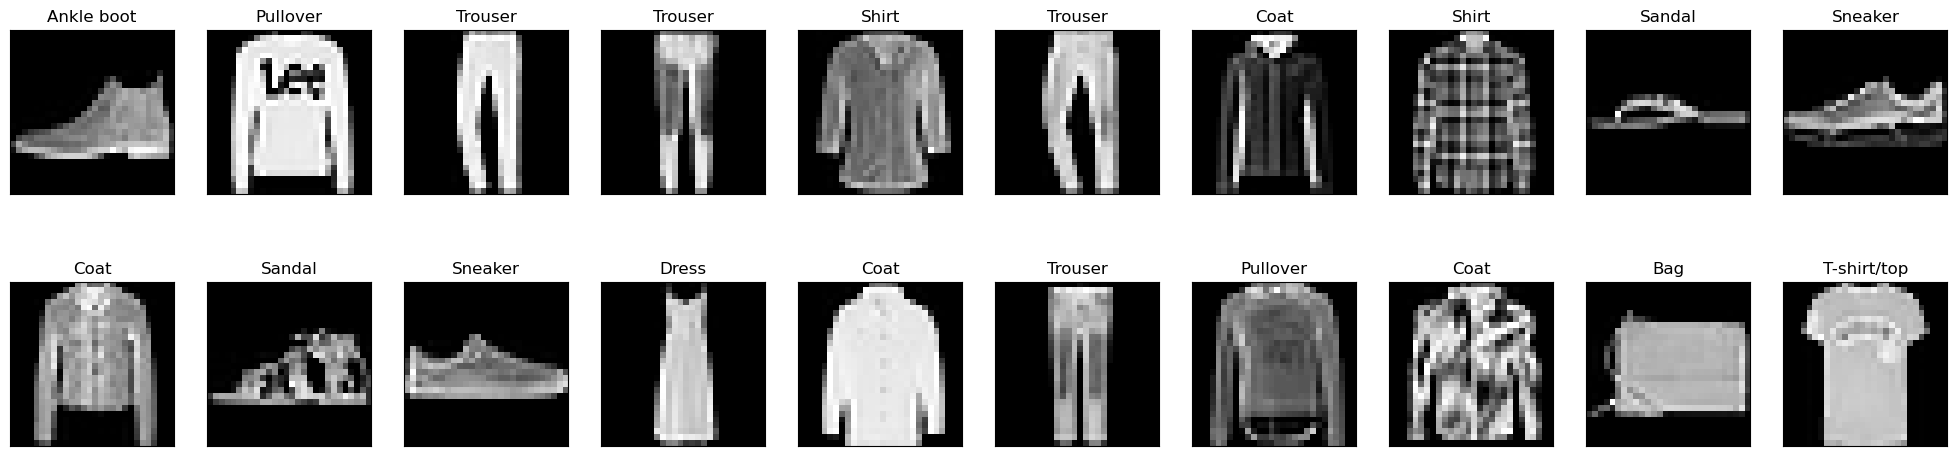

In [24]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')  
    plt.title(class_names[y])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [25]:
# Your code here